# Load dependencies

In [1]:
import numpy as np, sympy, matplotlib, matplotlib.pyplot as plt, scipy.optimize
from stl import mesh
from sympy.solvers.solveset import linsolve,nonlinsolve
# Enable this for interactive graphs in the browser, but be aware they're kinda weird
%matplotlib ipympl

# Mesh loading

You can replace this with your own mesh handling solution if desired, more examples are bundled with the repository

## How to make meshes

- Pull obj from [acidome](https://acidome.com/lab/calc/#1/2_Piped_D20_2V_R2.5_beams_20x20) (linked example is below)
- Reduce timber size to 1mm
- Download OBJ
- Load into blender
- Enter edit mode (tab)
- Perform a vertex merge by distance (Mesh -> Merge -> By Distance) and set the distance such that the dome's vertices become single vertices in the model
- Select all vertices on the model, and create faces; then delete the bottom face
- Save that as an STL

In [2]:
dome_mesh = mesh.Mesh.from_file('examples/1500mm-max-edge/v2dome1over2.stl')

Below defines the structure we use internally; names are bad but this wasn't going to be released this soon

In [3]:
dome_true_verts = np.unique(np.concatenate((dome_mesh.v0,dome_mesh.v1,dome_mesh.v2),axis=0),axis=0)
dome_true_tris = [];
for i in range(len(dome_mesh.v0)):
    a = b = c = -1
    for j in range(len(dome_true_verts)):
        if (dome_true_verts[j] == dome_mesh.v0[i]).all():
            a = j
        if (dome_true_verts[j] == dome_mesh.v1[i]).all():
            b = j
        if (dome_true_verts[j] == dome_mesh.v2[i]).all():
            c = j
    dome_true_tris.append([a,b,c])
dome_true_connections = []
for tri in dome_true_tris:
    dome_true_connections.append([tri[0], tri[1]])
    dome_true_connections.append([tri[1], tri[2]])
    dome_true_connections.append([tri[2], tri[0]])
dome_true_connections = np.unique(dome_true_connections, axis=0)
dome_true_adjacency = [[] for i in range(len(dome_true_verts))]
for conn in dome_true_connections:
    dome_true_adjacency[conn[0]].append(conn[1])

Print the dome so we can validate it looks correct

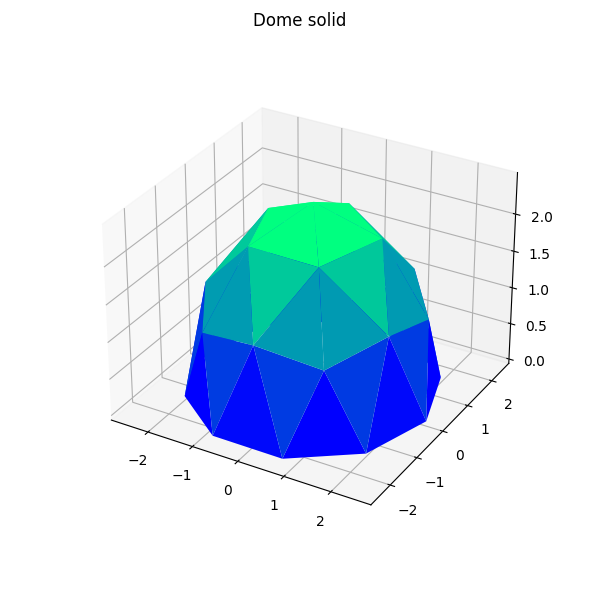

In [4]:
fig = plt.figure(1,figsize=(6,6))
fig.suptitle('Dome solid')
ax = plt.axes(projection='3d')

# Data for three-dimensional scattered points
verts = dome_true_verts
tri = dome_true_tris
tris = matplotlib.tri.Triangulation(verts[:,0], verts[:,1], tri)
ax.plot_trisurf(tris, verts[:,2], cmap='winter', linewidth=10.0);
fig.add_axes(ax)
plt.show()

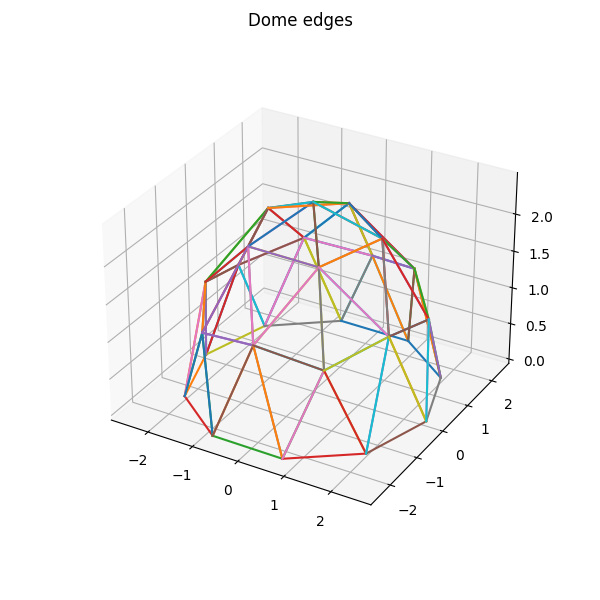

In [5]:
fig = plt.figure(2,figsize=(6,6))
fig.suptitle('Dome edges')
ax = plt.axes(projection='3d')

# Data for three-dimensional scattered points
for pair in dome_true_connections:
    verts = np.array([dome_true_verts[pair[0]], dome_true_verts[pair[1]]])
    ax.plot(verts[:,0], verts[:,1], verts[:,2], )
fig.add_axes(ax)
plt.show()

# FEA setup

Below is the code for doing FEA

[Recommended reading for understanding](https://www.youtube.com/watch?v=ohr4whqtduo)

In [6]:
# Sympy symbolic for viewing the matrix
def produce_stiffness_matrix_sympy(label="", uniform_params=False):
    elastic_modulus = sympy.Symbol(f"E") if uniform_params else sympy.Symbol(f"E_{label}")
    shear_modulus   = sympy.Symbol(f"G") if uniform_params else sympy.Symbol(f"G_{label}")
    length          = sympy.Symbol(f"L") if uniform_params else sympy.Symbol(f"L_{label}")
    area            = sympy.Symbol(f"A") if uniform_params else sympy.Symbol(f"A_{label}")
    moi_p           = sympy.Symbol(f"J") if uniform_params else sympy.Symbol(f"J_{label}")
    moi_y           = sympy.Symbol(f"I_y") if uniform_params else sympy.Symbol(f"I_{label}_y")
    moi_z           = sympy.Symbol(f"I_z") if uniform_params else sympy.Symbol(f"I_{label}_z")
    stiffness = sympy.Matrix([[elastic_modulus*area/length,0,0,0,0,0,-elastic_modulus*area/length,0,0,0,0,0],
                             [0,12*elastic_modulus*moi_z/(length**3),0,0,0,6*elastic_modulus*moi_z/(length**2),
                             0,-12*elastic_modulus*moi_z/(length**3),0,0,0,6*elastic_modulus*moi_z/(length**2)],
                             [0,0,12*elastic_modulus*moi_y/(length**3),0,-6*elastic_modulus*moi_y/(length**2),0,
                             0,0,-12*elastic_modulus*moi_y/(length**3),0,-6*elastic_modulus*moi_y/(length**2),0],
                             [0,0,0,shear_modulus*moi_p/length,0,0,0,0,0,-shear_modulus*moi_p/length,0,0],
                             [0,0,-6*elastic_modulus*moi_y/(length**2),0,4*elastic_modulus*moi_y/(length**1),0,
                             0,0,6*elastic_modulus*moi_y/(length**2),0,2*elastic_modulus*moi_y/(length**1),0],
                             [0,6*elastic_modulus*moi_z/(length**2),0,0,0,4*elastic_modulus*moi_z/(length**1),
                             0,-6*elastic_modulus*moi_z/(length**2),0,0,0,2*elastic_modulus*moi_z/(length**1)],
                             [-elastic_modulus*area/length,0,0,0,0,0,elastic_modulus*area/length,0,0,0,0,0],
                             [0,-12*elastic_modulus*moi_z/(length**3),0,0,0,-6*elastic_modulus*moi_z/(length**2),
                             0,12*elastic_modulus*moi_z/(length**3),0,0,0,-6*elastic_modulus*moi_z/(length**2)],
                             [0,0,-12*elastic_modulus*moi_y/(length**3),0,6*elastic_modulus*moi_y/(length**2),0,
                             0,0,12*elastic_modulus*moi_y/(length**3),0,6*elastic_modulus*moi_y/(length**2),0],
                             [0,0,0,-shear_modulus*moi_p/length,0,0,0,0,0,shear_modulus*moi_p/length,0,0],
                             [0,0,-6*elastic_modulus*moi_y/(length**2),0,2*elastic_modulus*moi_y/(length**1),0,
                             0,0,6*elastic_modulus*moi_y/(length**2),0,4*elastic_modulus*moi_y/(length**1),0],
                             [0,6*elastic_modulus*moi_z/(length**2),0,0,0,2*elastic_modulus*moi_z/(length**1),
                             0,-6*elastic_modulus*moi_z/(length**2),0,0,0,4*elastic_modulus*moi_z/(length**1)],
                             ])
    return stiffness

Below is the actual code

First is the stiffness matrix for a member, then is the coordinate transform matrix

In [7]:
def calc_stiffness_matrix(elastic_modulus, shear_modulus, length, area, moi_y, moi_z):
    moi_p = moi_y + moi_z
    stiffness = np.zeros((12,12))
    stiffness[0+0,0+0] = elastic_modulus*area/length
    stiffness[0+0,6+0] = -elastic_modulus*area/length
    stiffness[0+1,0+1] = 12*elastic_modulus*moi_z/(length**3)
    stiffness[0+1,0+5] = 6*elastic_modulus*moi_z/(length**2)
    stiffness[0+1,6+1] = -12*elastic_modulus*moi_z/(length**3)
    stiffness[0+1,6+5] = 6*elastic_modulus*moi_z/(length**2)
    stiffness[0+2,0+2] = 12*elastic_modulus*moi_y/(length**3)
    stiffness[0+2,0+4] = -6*elastic_modulus*moi_y/(length**2)
    stiffness[0+2,6+2] = -12*elastic_modulus*moi_y/(length**3)
    stiffness[0+2,6+4] = -6*elastic_modulus*moi_y/(length**2)
    stiffness[0+3,0+3] = shear_modulus*moi_p/length
    stiffness[0+3,6+3] = -shear_modulus*moi_p/length
    stiffness[0+4,0+2] = -6*elastic_modulus*moi_y/(length**2)
    stiffness[0+4,0+4] = 4*elastic_modulus*moi_y/(length**1)
    stiffness[0+4,6+2] = 6*elastic_modulus*moi_y/(length**2)
    stiffness[0+4,6+4] = 2*elastic_modulus*moi_y/(length**2)
    stiffness[0+1,0+1] = 6*elastic_modulus*moi_z/(length**2)
    stiffness[0+1,0+5] = 4*elastic_modulus*moi_z/(length**1)
    stiffness[0+1,6+1] = -6*elastic_modulus*moi_z/(length**2)
    stiffness[0+1,6+5] = 2*elastic_modulus*moi_z/(length**1)
    stiffness[6+0:6+6,:] = -stiffness[0+0:0+6,:]
    return stiffness

In [8]:
def normalize(v):
    norm = np.linalg.norm(v)
    if norm == 0: 
        return v
    return v / norm

def calc_transform_matrix(X_a, X_b):
    transform = np.zeros((12,12))
    gamma = np.zeros((3, 3))
    gamma[0,:] = normalize(X_b-X_a)
    V = np.array([1,0,0])
    gamma[2,:] = normalize(np.cross(normalize(gamma[0,:]), normalize(V)))
    gamma[1,:] = np.cross(normalize(gamma[2,:]), normalize(gamma[0,:]))
    transform[0*3+0:0*3+3,0*3+0:0*3+3] = gamma
    transform[1*3+0:1*3+3,1*3+0:1*3+3] = gamma
    transform[2*3+0:2*3+3,2*3+0:2*3+3] = gamma
    transform[3*3+0:3*3+3,3*3+0:3*3+3] = gamma
    return transform

Below is validation testing to ensure that T is correct (T should be \[Missing word\] such `T' == 1/T`)

In [9]:
T = calc_transform_matrix(np.array([0,0,0]), np.array([10,10,10]))

In [10]:
T_test = (np.transpose(T) - np.linalg.inv(T))
((T_test == 0) | (np.abs(T_test) < 10**-15)).all()

True

Testing

If you modify this make sure to use `matmul` instead of just `*`

In [11]:
np.matmul(calc_stiffness_matrix(1, 2, 3, 4, 5, 6),T)[0]

array([ 0.76980036,  0.76980036,  0.76980036,  0.        ,  0.        ,
        0.        , -0.76980036, -0.76980036, -0.76980036,  0.        ,
        0.        ,  0.        ])

In [12]:
(calc_stiffness_matrix(1, 2, 3, 4, 5, 6)*T)[0]

array([ 0.76980036,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        , -0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ])

# Do analysis

Below is the code of doing the analysis and is thus less general than the above FEA stuff

In [13]:
def add_link(global_k, elastic_modulus, shear_modulus, area, moi_y, moi_z, start_vertex_idx, end_vertex_idx, verts):
    start_mat_index = start_vertex_idx*6
    end_mat_index = end_vertex_idx*6
    length = np.linalg.norm(verts[start_vertex_idx] - verts[end_vertex_idx])
    local_k = calc_stiffness_matrix(elastic_modulus, shear_modulus, length, area, moi_y, moi_z)
    T = calc_transform_matrix(verts[start_vertex_idx], verts[end_vertex_idx])
    transformed_k = np.matmul(np.matmul(np.transpose(T),local_k),T)
    global_k[start_mat_index+0:start_mat_index+6, start_mat_index+0:start_mat_index+6] += transformed_k[0+0:0+6,0+0:0+6]
    global_k[end_mat_index+0:end_mat_index+6, start_mat_index+0:start_mat_index+6] += transformed_k[6+0:6+6,0+0:0+6]
    global_k[start_mat_index+0:start_mat_index+6, end_mat_index+0:end_mat_index+6] += transformed_k[0+0:0+6,6+0:6+6]
    global_k[end_mat_index+0:end_mat_index+6, end_mat_index+0:end_mat_index+6] += transformed_k[6+0:6+6,6+0:6+6]
    return global_k

In [14]:
def apply_position_constraint(F, K, index, value):
    F[index] = value
    offset = K[:,index]
    offset[index] = 0
    F -= value*offset
    K[index,:] = 0    
    K[:,index] = 0
    K[index,index] = 1
    return (F, K)

def apply_force_constraint(F, K, index, value):
    F[index] += value
    return (F, K)

## Tunables

In [15]:
# Setup params
# Assumes: 20mmx2mm wall
# Cite: https://www.thyssenkrupp-materials.co.uk/aluminium-6060.html
# Cite: https://www.omnicalculator.com/math/moment-of-inertia
# Cite: https://www.omnicalculator.com/math/cross-sectional-area
elastic_modulus = 70*1_000_000_000 # GPa
shear_modulus = 26.1*1_000_000_000 # GPa
area = 0.0001131
moi_y = 0.00000000463699 # Done by taking MOI(R=OD/2)-MOI(R=(OD/2)-Wall)
moi_z = 0.00000000463699 # Remember to put it into Meters because metric units :P

In [16]:
# Forces on ground nodes will be ignored
forces = np.zeros(dome_true_verts.shape)
forces[:,2] = (-1000)#/len(dome_true_verts) # Apply 1000N downwards (X:0, Y:1, Z:2) and Z- is down in our examples
forces[:,1] = (25*9.81)/len(dome_true_verts) # Example wind loading

In [17]:
# Other tunables
anchor_all_grounds = True # Try both values when doing wind testing; no need for purely z loading
fix_rotation = True # This is not implemented

## Matrix setup

In [18]:
# Allocate vectors
num_nodes = len(dome_true_verts)
F = np.zeros(6*num_nodes)
K = np.zeros([6*num_nodes, 6*num_nodes])

added_links = []

# Fill stiffness
for i in range(len(dome_true_verts)):
    for conn in dome_true_adjacency[i]:
        pair = (min(i, conn), max(i, conn))
        if (pair not in added_links):
            K = add_link(K, elastic_modulus, shear_modulus, area, moi_y, moi_z, i, conn, dome_true_verts)
            added_links.append(pair)

assert(fix_rotation) # TODO Fix ME

# Apply constraints
is_first_grounded = False
for i in range(len(dome_true_verts)):
    is_grounded = np.isclose(dome_true_verts[i,2],np.min(dome_true_verts[:,2]), atol=0.1)
    for j in range(3):
        F, K = apply_position_constraint(F, K, (i*6)+3+j, 0)
        #F, K = apply_force_constraint(F, K, (i*6)+3+j, 0)
    if (is_grounded):
        F, K = apply_position_constraint(F, K, (i*6)+2, 0)
        if not is_first_grounded:
            F, K = apply_position_constraint(F, K, (i*6)+1, 0)
            F, K = apply_position_constraint(F, K, (i*6)+0, 0)
            is_first_grounded = not anchor_all_grounds
    else:
        for j in range(3):
            F, K = apply_force_constraint(F, K, (i*6)+j, forces[i,j])

### Debug the stiffness matrix

In [19]:
with np.printoptions(threshold=np.inf):
    print(np.linalg.inv(K))

[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000

## Calculate result

In [20]:
U_result = np.matmul(F,np.linalg.inv(K))

## Print result

Rememeber that the result format is `(U_x, U_y, U_z, θ_x, θ_y, θ_z)` where `U` and `θ` are positional and rotational displacements, all in the global frame

In [21]:
U_result

array([ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00, -1.77027998e-04,  5.98169173e-05,
       -1.73551494e-04,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
       -1.82129768e-04, -5.01331883e-05, -1.83751321e-04,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00, -1.05646332e-04, -1.36426147e-04,
       -1.77299696e-04,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
       -1.07174598e-04,  1.52996373e-04, -1.86804212e-04,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  3.13946796e-05,  1.54203825e-06,
       -6.04028944e-04,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  

# View results

You can view change the deformation multiplier with `mult_factor`

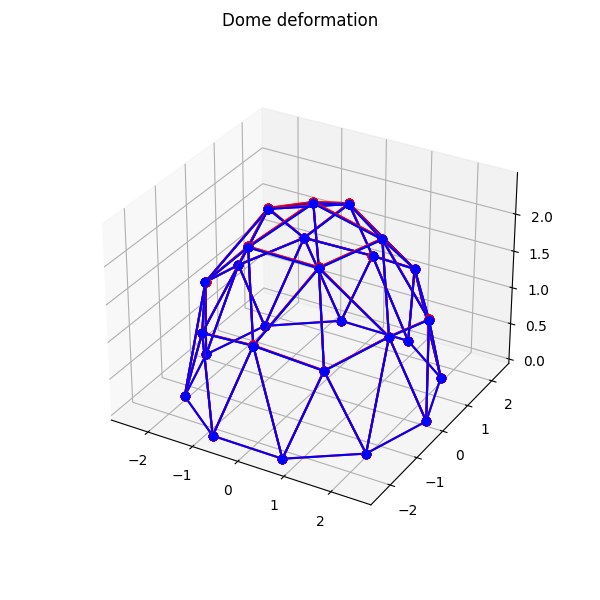

In [22]:
mult_factor = 20

fig = plt.figure(3,figsize=(6,6))
fig.suptitle('Dome deformation')
ax = plt.axes(projection='3d')

# Data for three-dimensional scattered points
for pair in dome_true_connections:
    verts = np.array([dome_true_verts[pair[0]], dome_true_verts[pair[1]]])
    ax.plot(verts[:,0], verts[:,1], verts[:,2], "ro-")
    verts[0] += mult_factor*U_result[pair[0]*6+0:pair[0]*6+3]
    verts[1] += mult_factor*U_result[pair[1]*6+0:pair[1]*6+3]
    ax.plot(verts[:,0], verts[:,1], verts[:,2], "bo-")
fig.add_axes(ax)
plt.show()

# Calculate stress, strain, and loading

This is done using defined mechanical properties

If you have used `anchor_all_grounds` theen be aware that the ground members SHOULD have 0 load (as they are between unmoving points)

In [23]:
evald_links = []
verts = dome_true_verts

# Fill stiffness
for i in range(len(dome_true_verts)):
    for conn in dome_true_adjacency[i]:
        pair = (min(i, conn), max(i, conn))
        if (pair not in evald_links):
            U_A = np.zeros(12)
            U_A[0+0:0+6] = U_result[pair[0]*6+0:pair[0]*6+6]
            U_A[6+0:6+6] = U_result[pair[1]*6+0:pair[1]*6+6]
            T = calc_transform_matrix(verts[pair[0]], verts[pair[1]])
            L = np.linalg.norm(verts[pair[0]] - verts[pair[1]])
            U_L = np.matmul(U_A, T)
            displacement = np.abs(U_L[0]-U_L[6])
            strain = displacement/L
            stress = (displacement/L)*elastic_modulus
            force = stress*area
            print(f"{pair[0]} <-> {pair[1]} --results-- stress: {stress}Pa, strain:{strain}, load:{force}N")

0 <-> 1 --results-- stress: 513275.1956457843Pa, strain:7.332502794939776e-06, load:58.0514246275382N
0 <-> 3 --results-- stress: 0.0Pa, strain:0.0, load:0.0N
0 <-> 4 --results-- stress: 4711914.454232745Pa, strain:6.731306363189635e-05, load:532.9175247737235N
0 <-> 1 --results-- stress: 513275.1956457843Pa, strain:7.332502794939776e-06, load:58.0514246275382N
1 <-> 2 --results-- stress: 2492407.605739811Pa, strain:3.5605822939140154e-05, load:281.89130020917264N
1 <-> 4 --results-- stress: 5788345.743205052Pa, strain:8.269065347435789e-05, load:654.6619035564913N
1 <-> 6 --results-- stress: 5948820.590923916Pa, strain:8.498315129891308e-05, load:672.8116088334948N
1 <-> 7 --results-- stress: 4642621.924716297Pa, strain:6.632317035308995e-05, load:525.0805396854131N
0 <-> 2 --results-- stress: 0.0Pa, strain:0.0, load:0.0N
1 <-> 2 --results-- stress: 2492407.605739811Pa, strain:3.5605822939140154e-05, load:281.89130020917264N
2 <-> 6 --results-- stress: 3580709.5951887732Pa, strain:5.1